In [93]:
import sys
sys.path.append('../../')
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython import embed; embed()
from sklearn.datasets import make_moons, make_blobs
from lib.computational_graph_approach.layers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


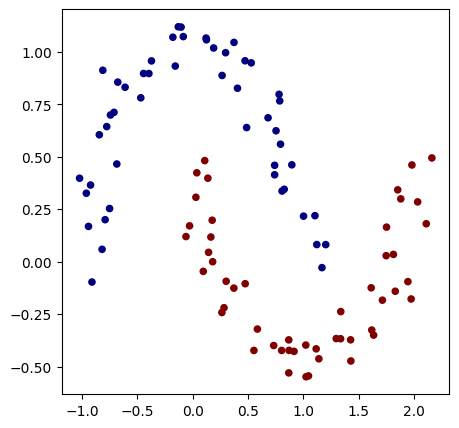

In [94]:
np.random.seed(1337)
random.seed(1337)

# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [95]:
class NN(Network):

    def __init__(self):
        self.layers = [
            FC(2, 16, "relu"),
            FC(16, 16, "relu"),
            FC(16, 1)
        ]

    def __call__(self, input):
        x = self.layers[0](input)
        x = self.layers[1](x)
        x = self.layers[2](x)
        return x
    
# Instantiate the model
model = NN()

In [96]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.val > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

0.29312885186615373 0.5


In [97]:
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    # for p in model.parameters():
        # print(p)
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.val -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.val}, accuracy {acc*100}%")

/Users/sujaygarlanka/Code/567-final-project/code/tests/computational_graph/../../lib/computational_graph_approach/value.py:7: RuntimeWarning: overflow encountered in scalar add
  val_a.grad += grad


step 0 loss 0.29312885186615373, accuracy 50.0%


/Users/sujaygarlanka/Code/567-final-project/code/tests/computational_graph/../../lib/computational_graph_approach/value.py:17: RuntimeWarning: overflow encountered in scalar add
  val_a.grad = val_a.grad + grad if val_a.val > 0 else val_a.grad


step 1 loss 0.29312885186615373, accuracy 50.0%
step 2 loss 0.29312885186615373, accuracy 50.0%
step 3 loss 0.29312885186615373, accuracy 50.0%
step 4 loss 0.29312885186615373, accuracy 50.0%
step 5 loss 0.29312885186615373, accuracy 50.0%
step 6 loss 0.29312885186615373, accuracy 50.0%
step 7 loss 0.29312885186615373, accuracy 50.0%
step 8 loss 0.29312885186615373, accuracy 50.0%
step 9 loss 0.29312885186615373, accuracy 50.0%
step 10 loss 0.29312885186615373, accuracy 50.0%
step 11 loss 0.29312885186615373, accuracy 50.0%
step 12 loss 0.29312885186615373, accuracy 50.0%
step 13 loss 0.29312885186615373, accuracy 50.0%
step 14 loss 0.29312885186615373, accuracy 50.0%
step 15 loss 0.29312885186615373, accuracy 50.0%
step 16 loss 0.29312885186615373, accuracy 50.0%
step 17 loss 0.29312885186615373, accuracy 50.0%
step 18 loss 0.29312885186615373, accuracy 50.0%
step 19 loss 0.29312885186615373, accuracy 50.0%
step 20 loss 0.29312885186615373, accuracy 50.0%
step 21 loss 0.29312885186615

KeyboardInterrupt: 

(-1.548639298268643, 1.951360701731357)

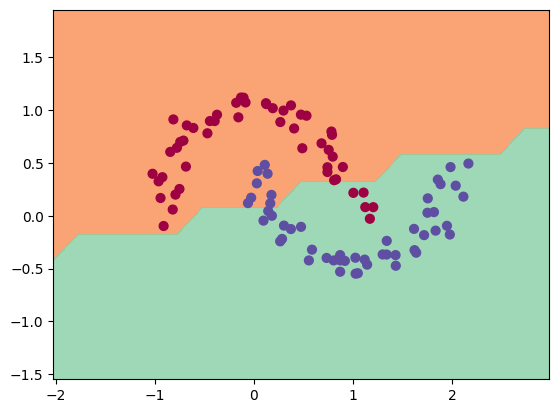

In [90]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.val > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())